# 做一个就图片上文字切割，并保证其顺序


In [17]:
import cv2
import numpy as np
import pyzbar.pyzbar as pyzbar
import pytesseract
import matplotlib.pyplot as plt
import time
import re
import sys

import imutils
from imutils.perspective import four_point_transform


In [18]:
img_url = r"F:\PYcode\Coding\ic\license\source_img\4.jpg"

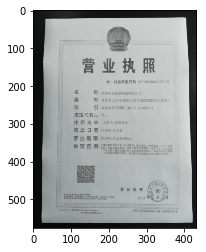

In [19]:
# 图片进行两次下采样
source_img = cv2.imread(img_url,  cv2.IMREAD_UNCHANGED)

down_img = cv2.pyrDown(source_img)
re_down_img = cv2.pyrDown(down_img)
re_down_img1 = cv2.pyrDown(re_down_img)

# ret2, th2 = cv2.threshold(source_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Otsu 滤波
cv2.imwrite("th2.jpg",re_down_img1)
plt.imshow(re_down_img1)
plt.show()

In [20]:
cv2.imshow("source_img", re_down_img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
gray_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
ret2, th2 = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Otsu 滤波

In [22]:
source_img = cv2.imread(img_url,  cv2.IMREAD_UNCHANGED)


In [23]:
width1, height1 =  source_img.shape[:2]
print(width1)
print(height1)

4608
3456


In [37]:
# 四边形矫正
def change_size(image):
    # 读取图片
    width1, height1 = image.shape[:2]
    # 转灰色
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 高斯滤波
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # 自适应二值化方法
    blurred=cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,51,2)
    # 找到边框
    edged = cv2.Canny(blurred, 10, 100)
    # 找到矩阵
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    docCnt = None
    if len(cnts) > 0:
        # 将轮廓按大小降序排序
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        # 对排序后的轮廓循环处理
        for c in cnts:
            # 获取近似的轮廓
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            # 如果近似轮廓有四个顶点，那么就认为找到了图片
            if len(approx) == 4:
                docCnt = approx
                break
    newimage = image.copy()
    for i in docCnt:
        #circle函数为在图像上作图，新建了一个图像用来演示四角选取
        cv2.circle(newimage, (i[0][0],i[0][1]), 10, (255, 0, 0), -1)
    # 使用transform 做映射
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    outimg = paper[int(paper.shape[0]*0.02):int(paper.shape[0]*0.98), int(paper.shape[1]*0.02):int(paper.shape[1]*0.98)]
    
    cv2.imwrite("resoutlicence.jpg", outimg)
    return outimg

In [38]:
#  从上倒下分隔图片
def getImageVerticalSum(image):
    # ImageThre = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ImageThre = image
    ret, ImageThre=cv2.threshold(ImageThre, 125,255, cv2.THRESH_BINARY_INV)
    rows, cols = ImageThre.shape[:2]
    versum = []
    for i in range(rows):
        val = np.array(ImageThre[i, :]).sum()
        versum.append(val)
    return versum  

#  从左倒右分隔图片
def getImageHorizontal(image):
    # ImageThre = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ImageThre = image
    ret, ImageThre=cv2.threshold(ImageThre, 170,255, cv2.THRESH_BINARY_INV)
    rows, cols = ImageThre.shape[:2]
    horsum = []
    for i in range(cols):
        val = np.array(ImageThre[:, i]).sum()
        horsum.append(val)
#     print(horsum)
    return horsum

In [39]:
versum = getImageVerticalSum(source_img)

In [29]:
horsum = getImageHorizontal(source_img)

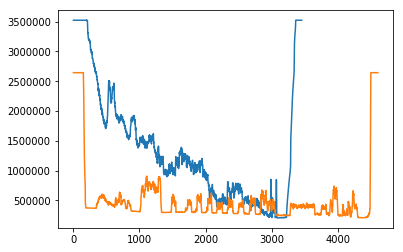

In [31]:
rows, cols = source_img.shape[:2]
X = np.arange(0,cols,1)
plt.plot(X,horsum)
X = np.arange(0,rows,1)
plt.plot(X,versum)
plt.show()

In [32]:
#这个函数我们最终需要找到一个区间表示字符的竖直分布情况
def getVerticalCharPosition(versum):
    result=[] #用来保存找到的结果：位置，区间大小
    deal_result = [[0,0]]
    i = 0
    while i< len(versum):
        if(versum[i] > 500):
            j=1 #代表这个区间的大小
            sumver = versum[i] #代表这整个区间的像素和是多少
            while(versum[i+j] > 500):
                sumver = sumver + versum[i + j]
                j = j + 1     
                if i+j == len(versum):
                    break
            if j > 60 and sumver > 4000: 
                result.append([i, j])
            i = i + j + 1 #跳过这整个不为0的区间，开始寻找下一个区间
        i = i + 1
    # 从中间进行切割
#     for i in range(len(result)-2):
#         deal_s = int(result[i][0] + result[i][1] + (result[i+1][0]-result[i][0] - result[i][1])/2)
#         deal_d = int(result[i+1][0] + result[i+1][1] + (result[i+2][0]-result[i+1][0] - result[i+1][1])/2) - deal_s

#         deal_result.append([deal_s,deal_d])
        
#     deal_result.append(result[-1])
#     deal_result= deal_result[1:]
    return result

In [33]:
#这个函数我们最终需要找到一个区间表示字符的水平分布情况
def getHorizontalCharPosition(horsum):
    result = []  # 用来保存找到的结果：位置，区间大小
    i = 0
    while i < len(horsum):
        if(horsum[i]!=0):
            j=1 #代表这个区间的大小
            sumhor = horsum[i] #代表这整个区间的像素和是多少
            while(horsum[i+j] > 0):
                sumhor = sumhor + horsum[i + j]
                j = j + 1     
                if i+j == len(horsum):
                    break
            if j > 10 and sumhor > 2000: 
                result.append([i, j])
            i = i + j + 1 #跳过这整个不为0的区间，开始寻找下一个区间
        i = i + 1
    return result

In [34]:
# 这个函数返回所有可能是字符的图片区域
def getVerCharImages(verticalCharPosition, image):
    weight = image.shape[1]
    vercharImages = []
    for v in verticalCharPosition:
        vercharImages.append(image[v[0]: v[0]+v[1], 0: weight])
    return vercharImages 


def getHorCharImages(getHorizontalCharPosition, image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     _, img = cv2.threshold(image,125,255, cv2.THRESH_BINARY_INV)
    ret2, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    height = image.shape[0]
    horcharImages = []
    for h in getHorizontalCharPosition:
        horcharImages.append(img[0: height, h[0]:h[0]+h[1]])
    return horcharImages 


In [63]:
# for i in range(len(charImages)):
#     horsum = getImageHorizontal(charImages[i])
#     HrPosition = getHorizontalCharPosition(horsum)
#     print(HrPosition)
#     single_img = getHorCharImages(HrPosition, charImages[i])
#     u = 1
#     for x in single_img:   
#         try:
#             cv2.imwrite("%s,jpg"%(u),x)         
#         except:
#             pass
#         u += 1
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

In [172]:
horsum = getImageHorizontal(charImages[0])
HrPosition = getHorizontalCharPosition(horsum)

In [25]:
image = cv2.imread(img_url, cv2.IMREAD_UNCHANGED)
ch_img = change_size(image)
versum = getImageVerticalSum(ch_img)
verPosition = getVerticalCharPosition(versum)
verImage = getVerCharImages(verPosition, ch_img)

i = 1
for horImage in verImage:
    cv2.imwrite('{0:0>4}.jpg'.format(i), horImage)
    i+=1

In [42]:
def main():
    img_url = r"F:\PYcode\Coding\ic\license\source_img\AA.jpg"    
    image = cv2.imread(img_url, cv2.IMREAD_UNCHANGED)
    ch_img = change_size(image)
    versum = getImageVerticalSum(ch_img)
    verPosition = getVerticalCharPosition(versum)
    verImage = getVerCharImages(verPosition, ch_img)

    i = 1
    for horImage in verImage:
#         cv2.imwrite('{0:0>4}.jpg'.format(i), horImage)
        horsum = getImageHorizontal(horImage)
        horPosition = getHorizontalCharPosition(horsum)
        singleImage = getHorCharImages(horPosition, horImage)
        for out_img in singleImage:
            cv2.imwrite('img_re\{0:0>4}.jpg'.format(i), out_img)
            i += 1
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [43]:
main()

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\shapedescr.cpp:274: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::contourArea'


In [64]:
horimg = cv2.imread("0001.jpg")
image = cv2.cvtColor(horimg, cv2.COLOR_BGR2GRAY)

# ret, ImageThre=cv2.threshold(image, 180,255, cv2.THRESH_BINARY_INV)
blurred=cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,5,2)

ret2, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


In [65]:
cv2.imwrite('show.jpg', blurred)
cv2.imshow("1", blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [129]:
# bur = cv2.blur(horimg, (7,3))
# 二值化
bur = cv2.cvtColor(horimg, cv2.COLOR_BGR2GRAY)
# retval,threshold = cv2.threshold(bur,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # 闭运算，
kernel1 = np.ones((3,3),np.uint8)  
imgc = cv2.morphologyEx(bur,cv2.MORPH_CLOSE, kernel1)

a, contours, hierarchy = cv2.findContours(imgc,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 

In [120]:
box_list = []
i = 1
for contour in contours:
    if cv2.contourArea(contour) < 10:
        continue
    else:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(horimg, [box], 0, (0, 0, 255), 1)
        box_list.append(box)
        x, y, w, h = cv2.boundingRect(box)
        resout = pytesseract.image_to_string(horimg[y:(y+h), x:(x+w)], lang='chi_sim')
#         if resout:
        cv2.imwrite("img_out\q%s.jpg"%(i), horimg[y:(y+h), x:(x+w)])
#             print("img%s"%(i), resout)
        i += 1

In [82]:
i=1
horsum = getImageHorizontal(horimg)

horPosition = getHorizontalCharPosition(horsum)
singleImage = getHorCharImages(horPosition, horimg)
for out_img in singleImage:
    cv2.imwrite(f"d{i}.jpg", out_img)
    i += 1


In [55]:
horPosition

[[0, 75]]

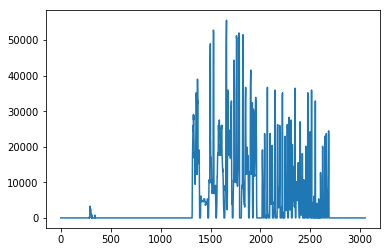

In [74]:
rows, cols = horimg.shape[:2]
X = np.arange(0,cols,1)
plt.plot(X,horsum)
# X = np.arange(0,rows,1)
# plt.plot(X,versum)
plt.show()

In [8]:
from PIL  import Image
import cv2 

In [9]:
img_url = r"F:\PYcode\Coding\ic\license\source_img\4.jpg"
img = Image.open(img_url)
opemcv_img = cv2.imread(img_url)

In [16]:
img.size

(3456, 4608)

In [13]:
opemcv_img = cv2.cvtColor(opemcv_img, cv2.COLOR_BGR2RGB)

In [17]:
opemcv_img.shape

(4608, 3456, 3)